<a href="https://colab.research.google.com/github/Humboldt-Penguin/Lightkurve-Exoplanets/blob/main/Lightkurve_Supernovae_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Background

## Installing Lightkurve (hide this cell)

In [ ]:
!pip install lightkurve

     |████████████████████████████████| 247 kB 5.2 MB/s 
     |████████████████████████████████| 4.5 MB 61.4 MB/s 
     |████████████████████████████████| 41 kB 167 kB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
     |████████████████████████████████| 832 kB 55.2 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 42.6 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=debe4fd71dcf817dcd3a8f5c4bd3450322dc08b91655259c01a7341f83e40c7c
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=341dc45dca28effbf3d7171d5b1c8175c00da28bc331f8d16997b37f5278fc56
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12779 s

The [TESS telescope](https://archive.stsci.edu/missions-and-data/tess) has four 4-megapixel charge-coupled device (CCD) cameras [or "photometers" if you want to be fancy] that collect light in the 600 to 1000 nm range. These data are often called **"pixel files"**.

\

For a star's designated location, Lightkurve will give us a target pixel file containing a 2D array of luminosity values over some period of time. Let's take a look at one of my favorite discoveries from the Kepler telescope, Tabby's Star!

First we download the target pixel file:

In [ ]:
from lightkurve import search_targetpixelfile

# Download pixelfile at a certain location and time (in this case, year 4 of Kepler's life)
tabby_pf = search_targetpixelfile("KIC 8462852", quarter=16).download(quality_bitmask='hardest');

Now can look at any individual frame of the pixel file:

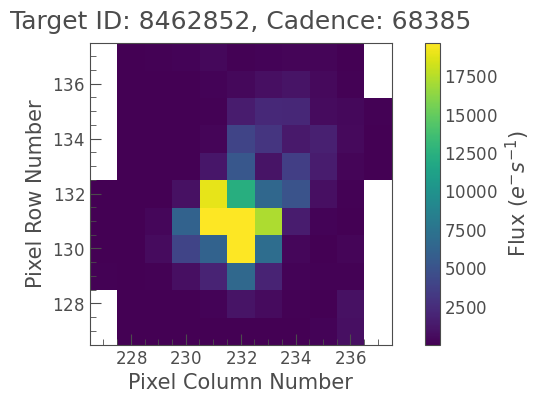

In [ ]:
tabby_pf.plot(frame=1000);

However, these are really only for visualization purposes. 


---
# 3. Supernovae Light Curves (Needs Documentation)

We can extract light curves of any transient phenomena, including supernovae. However this analysis presents a few unique challenges compared to looking at isolated point sources. Some basic limitations of our prior method include the fact that supernovae reside in a host galaxy which may itself change over time due to factors like active galactic nuclei (AGN). Common detrending methods, such as “Self Flat Fielding” (SFF) assume that movements of the supernova venter is entirely due to movement of the spacecraft, even though transience creates actual astrophysical motion as the photocenter gets weighted towards the increasingly bright transient’s photocenter.

\

As such, we aim to make a custom supernova lightcurve through the following:

1. Create an appropriate aperture mask to isolate the transient from its host galaxy

2. Extract aperture photometry of both the supernova and the background attributable to the host galaxy

3. Apply “Self Flat Fielding” (SFF) detrending techniques

4. Plot the lightcurve

\

We will focus on an unusual class of transient recently observed in K2, the so-called Fast-Evolving Luminous Transients or FELTs. These transients rise and fall within a mere few days, much shorter than conventional supernovae, which can last hundreds of days. The discovery of KSN2015k was recently reported by Rest et al. 2018 and summarized in at least two press releases from STSci and JPL.



In [ ]:
import numpy as np
from lightkurve import search_targetpixelfile

In [ ]:
tpf = search_targetpixelfile('EPIC 212593538', author="K2", campaign=6).download()
tpf.shape

(3545, 8, 8)

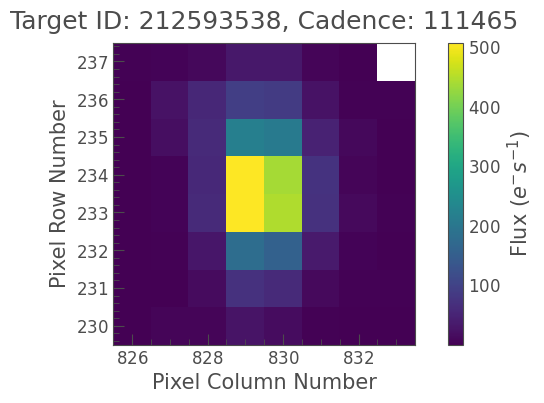

In [ ]:
tpf.plot(frame=100);

In [ ]:
postage_stamp_mask = tpf.hdu[2].data > 0
postage_stamp_mask.sum()

63

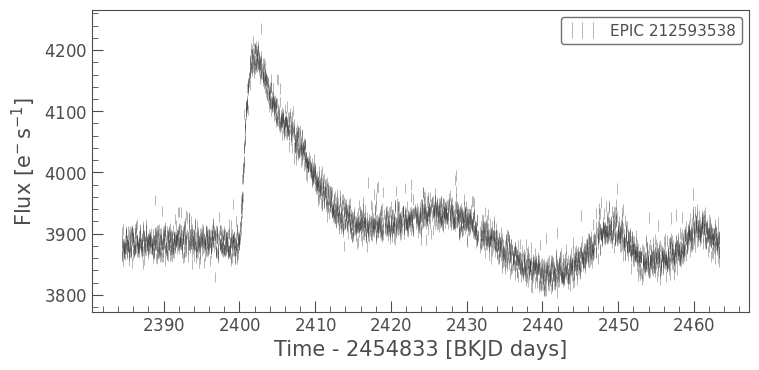

In [ ]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]
lc_clean.errorbar(alpha=0.5, normalize=False);

We indeed see what looks like a sharply-rising phenomenon at 2400 - 2415 days, distinct from the smoothly-varying background, which could arise from either instrumental artifacts or host-galaxy.

\

Once we have our aperture and background masks, we can estimate the net flux:
$$
f_{net}(t)=f_{aper}(t)-f_b(t)\cdot N_{aper}
$$
where $f_{aper}$ is the total summed flux in an aperture of size $N_{aper}$ pixels, and $f_b$ is our estimate for the (spatially-flat) background level per pixel, in each cadence.

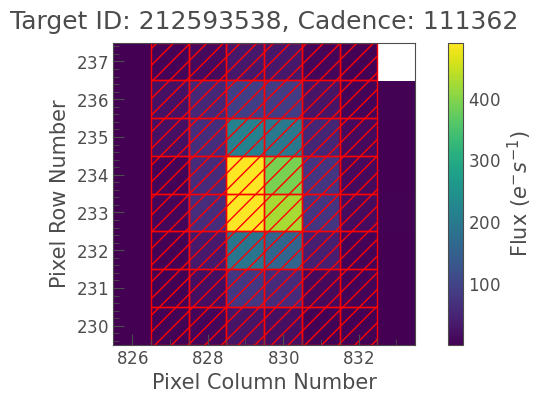

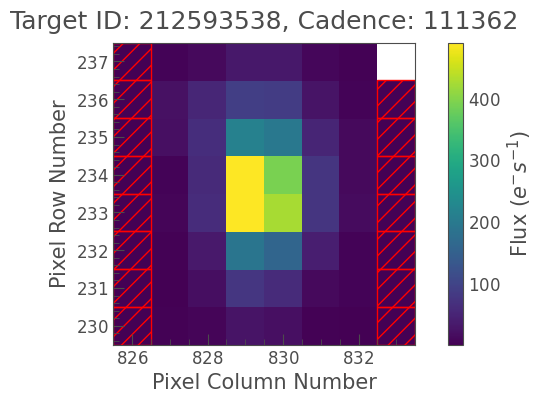

In [ ]:
aperture_mask = postage_stamp_mask.copy()
aperture_mask[:,-1] = False
aperture_mask[:,0] = False
background_mask = ~aperture_mask & postage_stamp_mask
N_targ_pixels, N_back_pixels = aperture_mask.sum(), background_mask.sum()
tpf.plot(aperture_mask=aperture_mask);
tpf.plot(aperture_mask=background_mask);

Now apply the equations and drop the previously-identified spurious cadences.

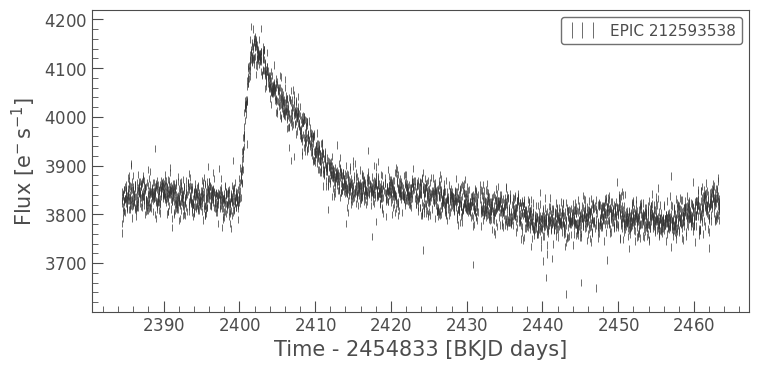

In [ ]:
lc_aper = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc_back_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / N_back_pixels
lc_net = lc_aper - lc_back_per_pixel.flux * N_targ_pixels

lc_net = lc_net[~spurious_cadences]
lc_net.errorbar();

We no longer see the instrumentally-induced background wiggles.
$\boxed{ } $